In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix,roc_auc_score
import shap
from imblearn.over_sampling import SMOTE,SMOTENC
import optuna

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('C:/Users/LG/Documents/GitHub/ML-project1/train.csv')

#check
X = data.drop(columns=['id','CustomerId', 'Surname','Exited'],axis=1).reset_index(drop=True)
y_true = data['Exited'].reset_index(drop=True)
print('전처리 완료:',X.shape,y_true.shape)
display(X.info())
print('----------------------------')


전처리 완료: (165034, 10) (165034,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 12.6+ MB


None

----------------------------


In [9]:
#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true,stratify = y_true,test_size = 0.2, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#over sampling
# SMOTE-NC 적용
# 범주형 변수의 인덱스 설정
cat_features = ['Geography','Gender']
smote_nc = SMOTENC(categorical_features=cat_features, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

# 증강 후 데이터 비율 확인
print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTENC:", y_train_res.value_counts())

X_train_res.info()

데이터 분리 후 크기 :  (132027, 10) (33007, 10) (132027,) (33007,)
Before SMOTE: Exited
0    0.788399
1    0.211601
Name: proportion, dtype: float64
After SMOTENC: Exited
0    104090
1    104090
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208180 entries, 0 to 208179
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      208180 non-null  int64  
 1   Geography        208180 non-null  object 
 2   Gender           208180 non-null  object 
 3   Age              208180 non-null  float64
 4   Tenure           208180 non-null  int64  
 5   Balance          208180 non-null  float64
 6   NumOfProducts    208180 non-null  int64  
 7   HasCrCard        208180 non-null  float64
 8   IsActiveMember   208180 non-null  float64
 9   EstimatedSalary  208180 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 15.9+ MB


In [11]:
# 파라미터 튜닝 
params = {
    'learning_rate':0.02678152407579277,  
    'depth': 8,   
    'n_estimators': 111, 
    'l2_leaf_reg':0.0008386712970316092
}

model = CatBoostClassifier(**params,random_state=42,cat_features=cat_features,verbose=False,class_weights={0:0.32,1:0.68})

model.fit(X_train_res, y_train_res) #범주형 인덱스 추가
y_pred = model.predict(X_test)

#임계값 조정
y_pred_prob = model.predict_proba(X_test)[:, 1]
threshold = 0.48  # threshold를 낮추어 recall을 높임
y_pred = (y_pred_prob >= threshold).astype(int)

print('ac:', accuracy_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print("AUC :", average_precision_score(y_test, y_pred))

ac: 0.7891659344987427
f1: 0.623410357703339
recall: 0.8247422680412371
precision: 0.5010874293170944
AUC : 0.45035102593281423


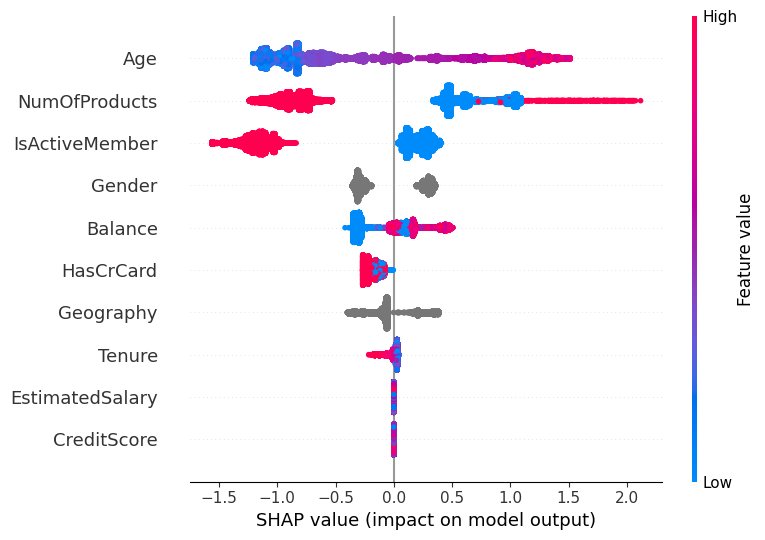

In [12]:
# SHAP 값 계산을 위한 Explainer 생성
explainer = shap.Explainer(model)  #학습 모델전달
shap_values = explainer(X_test)  # 테스트 데이터로 SHAP 값 계산

# Summary Plot (변수 중요도 시각화)
shap.summary_plot(shap_values, X_test)

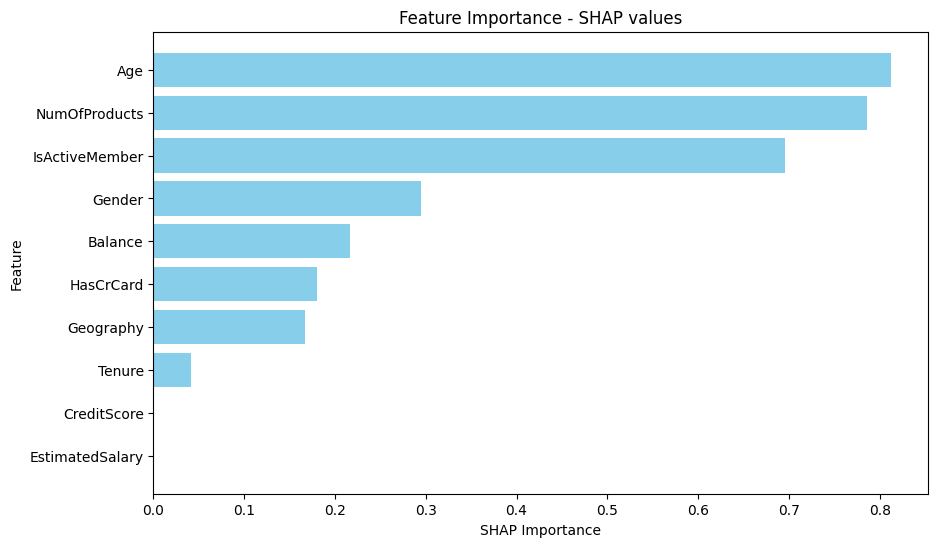

In [13]:
# Bar Plot (변수 중요도 막대 그래프) gtp 코드임 추가학습 필요
shap_values_array = shap_values.values  # SHAP 값 배열 추출
feature_names = X_test.columns  # 변수 이름 가져오기

# SHAP 평균 절대값 기준으로 변수 중요도 계산
shap_importance = np.abs(shap_values_array).mean(axis=0)
shap_importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP Importance': shap_importance})
shap_importance_df = shap_importance_df.sort_values(by="SHAP Importance", ascending=False)

# Bar Plot 그리기
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df["Feature"], shap_importance_df["SHAP Importance"], color='skyblue')
plt.xlabel("SHAP Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - SHAP values")
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위로 정렬
plt.show()


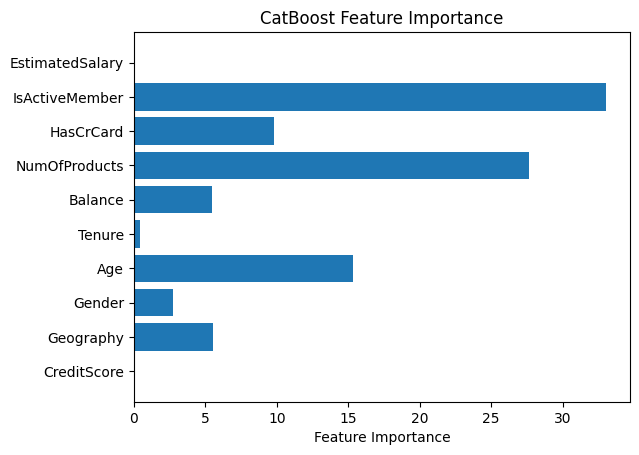

In [14]:
#주요 변수 시각화 
feature_importances = model.get_feature_importance()

# Feature importance 시각화
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), X_train.columns)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()